<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Analyze Facebook Data Using IBM Watson and IBM Watson Studio

This is a three-part notebook meant to show how anyone can enrich and analyze a combined dataset of unstructured and structured information with IBM Watson and IBM Watson Studio. For this example we are using a standard Facebook Analytics export which features texts from posts, articles and thumbnails, along with standard performance metrics such as likes, shares, and impressions. 

**Part I** will use the Natural Language Understanding, Visual Recognition and Tone Analyzer services from IBM Watson to enrich the Facebook posts, thumbnails, and articles by pulling out `Emotion Tones`, `Language Tones`, `Entities`, `Keywords`, and `Document Sentiment`. The end result of Part I will be additional features and metrics we can visualize in Part III. 

**Part II** will set up multiple pandas DataFrames that will contain the values, and metrics needed to find insights in the Part III tests and experiments.

**Part III** will use charts to visualize the features that we discovered during enrichment and show how they correlate with customer impressions.


#### You should only need to change data in the Setup portion of this notebook. All places where you see  <span style="color: red"> User Input </span> is where you should be adding inputs. 

### Table of Contents

### [**Part I - Enrich**](#part1)<br>
1. [Setup](#setup)<br>
   1.1 [Install Watson Developer Cloud and BeautifulSoup Packages](#setup1)<br>
   1.2 [Install PixieDust](#pixie)<br> 
   1.3 [Restart Kernel](#restart)<br> 
   1.4 [Import Packages and Libraries](#setup2)<br>
   1.5 [Add Service Credentials From IBM Cloud for Watson Services](#setup3)<br>
2. [Load Data](#load)<br>
   2.1 [Load Data From Cloud Object Storage as a pandas DataFrame](#load1)<br>
   2.2 [Set Variables](#load2)<br>
3. [Prepare Data](#prepare)<br>
   3.1 [Data Cleansing with Python](#prepare1)<br>
   3.2 [Beautiful Soup to Extract Thumbnails and Extented Links](#prepare2)<br>
4. [Enrich Data](#enrich)<br>
   4.1 [NLU for Post Text](#nlupost)<br>
   4.2 [NLU for Thumbnail Text](#nlutn)<br>
   4.3 [NLU for Article Text](#nlulink)<br>
   4.4 [Tone Analyzer for Post Text](#tonepost)<br>
   4.5 [Tone Analyzer for Article Text](#tonearticle)<br>
   4.6 [Visual Recognition](#visual)<br>
5. [Write Data](#write)<br>
   5.1 [Convert DataFrame to new CSV](#write1)<br>
   5.2 [Write Data to Cloud Object Storage](#write2)<br>
    
### [**Part II - Data Preparation**](#part2)<br>
1. [Prepare Data](#prepare)<br>
   1.1 [Create Multiple DataFrames for Visualizations](#visualizations)<br>
   1.2 [Create a Consolidated Tone DataFrame](#tone)<br>
   1.3 [Create a Consolidated Keyword DataFrame](#keyword)<br>
   1.4 [Create a Consolidated Entity DataFrame](#entity)<br>
  
### [**Part III - Analyze**](#part3)<br>

1. [Setup](#2setup)<br> 
    1.1 [Assign Variables](#2setup2)<br>
2. [Visualize Data](#2visual)<br>
    2.1 [Run PixieDust Visualization Library with Display() API](#2visual1)


# <a id="part1"></a>Part I - Enrich

## <a id="setup"></a>1. Setup
To prepare your environment, you need to install some packages and enter credentials for the Watson services.

### <a id="setup1"></a> 1.1 Install Latest Watson Developer Cloud and Beautiful Soup Packages
You need to install these packages:
 - [Watson Developer Cloud](https://github.com/watson-developer-cloud/python-sdk): a client library for Watson services.
 - <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/" target="_blank" rel="noopener noreferrer">Beautiful Soup</a>: a library to parse data from HTML for enriching the Facebook data.
 - <a href="https://ibm-cds-labs.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a>: a library to visualize the data. 

Install the Watson Developer Cloud package:

In [1]:
!pip -q install --user --no-warn-script-location ibm-watson==3.2.0

Install the Beautiful Soup package:

In [2]:
!pip -q install --user beautifulsoup4==4.8.0

<a id="pixie"></a>
### 1.2 Install PixieDust Library

In [3]:
!pip -q install --user --upgrade pixiedust==1.1.14

<a id="restart"></a>
### 1.3 Restart Kernel
> Required after installs/upgrades only.

If any libraries were just installed or upgraded, <span style="color: red">restart the kernel</span> before continuing. After this has been done once, you might want to comment out the `!pip install` lines above for cleaner output and a faster "Run All".

<a id="setup2"></a>
### 1.4 Import Packages and Libraries
> Tip: To check if you have a package installed, open a new cell and write: `help(<package-name>)`.

In [4]:
import json
import sys

from ibm_watson import ToneAnalyzerV3
from ibm_watson import VisualRecognitionV3
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, EmotionOptions, SentimentOptions

import operator
from functools import reduce
from io import StringIO
import numpy as np
from bs4 import BeautifulSoup as bs
from operator import itemgetter
from os.path import join, dirname
import pandas as pd
import numpy as np
import requests

# Suppress some pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'
# Suppress SSL warnings
requests.packages.urllib3.disable_warnings()

<a id='setup3'></a>
### 1.5 Add Service Credentials From IBM Cloud for Watson Services
Edit the following cell to provide your credentials for Watson Visual Recognition, Natural Language Understanding and Tone Analyzer.

You must create a Watson Natural Language Understanding service, a Watson Tone Analyzer service, and a Watson Visual Recognition service on [IBM Cloud](bluemix.net).

1. Create a service for [Natural Language Understanding (NLU)](https://www.ibm.com/watson/developercloud/natural-language-understanding.html). 
1. Create a service for [Tone Analyzer](https://cloud.ibm.com/catalog/services/tone-analyzer?taxonomyNavigation=watson).
1. Create a service for [Visual Recognition](https://cloud.ibm.com/catalog/services/visual-recognition).
1. Insert API keys and URLs in the following cell.
1. Run the cell.

###  <span style="color: red"> _User Input_</span> 

In [5]:
# @hidden_cell

# Watson Visual Recognition
VISUAL_RECOGNITION_API_KEY = ''
VISUAL_RECOGNITION_URL = ''

# Watson Natural Language Understanding (NLU)
NATURAL_LANGUAGE_UNDERSTANDING_API_KEY = ''
NATURAL_LANGUAGE_UNDERSTANDING_URL = ''

# Watson Tone Analyzer
TONE_ANALYZER_API_KEY = ''
TONE_ANALYZER_URL = ''


In [6]:
# Create the Watson clients

nlu = NaturalLanguageUnderstandingV1(version='2019-07-25',
                                    iam_apikey=NATURAL_LANGUAGE_UNDERSTANDING_API_KEY,
                                    url=NATURAL_LANGUAGE_UNDERSTANDING_URL)

tone_analyzer = ToneAnalyzerV3(version='2019-07-25',
                               iam_apikey=TONE_ANALYZER_API_KEY,
                               url=TONE_ANALYZER_URL)

visual_recognition = VisualRecognitionV3(version='2019-07-25',
                                         iam_apikey=VISUAL_RECOGNITION_API_KEY,
                                         url=VISUAL_RECOGNITION_URL)


## <a id='load'></a>2. Load Data
The data you'll analyzing is a sample of a standard export of the Facebook Insights Post information from the <a href="https://www.facebook.com/ibmwatson/" target="_blank" rel="noopener noreferrer">IBM Watson Facebook page</a>. Engagement metrics such as clicks, impressions, and so on, are altered and do not reflect actual post performance data. The data is on the Watson Studio community page.

### 2.1 Load the data as a pandas DataFrame

To get the data and load it into a pandas DataFrame:

1. Load the file by clicking the **Find and Add Data** icon and then dragging and dropping the file onto the pane or browsing for the file. The data is stored in the object storage container that is associated with your project.
1. Click in the next cell and then choose **Insert to code > Insert pandas DataFrame** from below the file name and then run the cell. Change the inserted variable name to `df_data_1`

###  <span style="color: red"> _User Input_</span> 

In [7]:
# **Insert to code > Insert pandas DataFrame**


,Post ID,Permalink,Post Message,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,...,Lifetime Matched Audience Targeting Consumptions by Type - other clicks,Lifetime Matched Audience Targeting Consumptions by Type - link clicks,Lifetime Matched Audience Targeting Consumptions by Type - photo view,Lifetime Matched Audience Targeting Consumptions by Type - video play,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - report_spam_clicks,Lifetime Negative Feedback by Type - hide_all_clicks,Lifetime Negative Feedback by Type - hide_clicks,Lifetime Negative Feedback by Type - report_spam_clicks
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lifetime: The number of people who had your Pa...,Lifetime: The number of people who had your Pa...,...,Lifetime: The number of clicks anywhere in the...,NaN,NaN,NaN,Lifetime: The number of times people have give...,NaN,NaN,Lifetime: The number of people who have given ...,NaN,NaN
1,187446750783_10156099244995784,https://www.facebook.com/ibmwatson/posts/10156...,"In 2018, IBM has made significant strides towa...",Link,NaN,NaN,12/26/18 9:22,,13560,13560,...,53,84.0,NaN,NaN,3,4.0,NaN,3,4.0,NaN
2,187446750783_10156082794855784,https://www.facebook.com/ibmwatson/posts/10156...,"Available now on IBM Cloud and Cloud Private, ...",Photo,NaN,NaN,12/18/18 7:15,,7837,7837,...,25,17.0,47.0,NaN,4,NaN,NaN,4,NaN,NaN
3,187446750783_10156079731075784,https://www.facebook.com/ibmwatson/posts/10156...,A year in review in AI: https://ibm.co/2QAlo29,Link,NaN,NaN,12/16/18 14:54,,10727,10727,...,39,129.0,NaN,NaN,3,4.0,NaN,3,4.0,NaN
4,187446750783_10156067568775784,https://www.facebook.com/ibmwatson/posts/10156...,IBM Watson,SharedVideo,NaN,NaN,12/10/18 14:06,,7937,7937,...,191,80.0,NaN,NaN,1,4.0,NaN,1,4.0,NaN


### <a id='load2'></a>2.2 Set variables
You need to set these variables:
 - The name of the DataFrame
 - Your credentials for the source file
 - A file name for the enriched DataFrame
 
Define a variable, `df`, for the DataFrame that you just created. If necessary, change the original DataFrame name to match the one you created.

In [8]:
# Make sure this uses the variable above. The number will vary in the inserted code.
try:
    df = df_data_1
except NameError as e:
    print('Error: Setup is incorrect or incomplete.\n')
    print('Follow the instructions to insert the pandas DataFrame above, and edit to')
    print('make the generated df_data_# variable match the variable used here.')
    raise

**Select the cell below and place your cursor on an empty line below the comment.** 
Put in the credentials for the file you want to enrich by clicking on the 10/01 (upper right), then click `Insert to code` under the file you want to enrich, and choose `Insert Credentials`.

**Change the inserted variable name to `credentials_1`**

###  <span style="color: red"> _User Input_</span> 

In [9]:
# insert credentials for file - Change to credentials_1


In [10]:
# Make sure this uses the variable above. The number will vary in the inserted code.
try:
    credentials = credentials_1
except NameError as e:
    print('Error: Setup is incorrect or incomplete.\n')
    print('Follow the instructions to insert the file credentials above, and edit to')
    print('make the generated credentials_# variable match the variable used here.')
    raise

<a id='prepare'></a>
## 3. Prepare Data
You'll prepare the data by cleansing it and extracting the URLs. Many of the posts contain both text and a URL. The first task is to separate URLs from the text so that they can be analyzed separately. Then you need to get thumbnails for the photos and links, and convert any shortened URLs to full URLs.

<a id='prepare1'></a>
###  3.1 Data Cleansing with Python
Renaming columns, removing noticeable noise in the data, pulling out URLs and appending to a new column to run through NLU.

To cleanse the data, you'll rename a column and add a column with the URLs that were embedded in the post. 

Change the name of the `Post Message` column to `Text`:

In [11]:
df.rename(columns={'Post Message': 'Text'}, inplace=True)

In [12]:
# Drop the rows that have NaN for the text.
df.dropna(subset=['Text'], inplace=True)

Use the `str.partition` function to remove strings that contain "http" and "www" from the `Text` column and save them in new DataFrames, then add all web addresses to a new `Link` column in the original DataFrame. This process captures all web addresses: https, http, and www.

In [13]:
df_http = df["Text"].str.partition("http")
df_www = df["Text"].str.partition("www")

# Combine delimiters with actual links
df_http["Link"] = df_http[1].map(str) + df_http[2]
df_www["Link1"] = df_www[1].map(str) + df_www[2]

# Include only Link columns
df_http.drop(df_http.columns[0:3], axis=1, inplace = True)
df_www.drop(df_www.columns[0:3], axis=1, inplace = True)

# Merge http and www DataFrames
dfmerge = pd.concat([df_http, df_www], axis=1)

# The following steps will allow you to merge data columns from the left to the right
dfmerge = dfmerge.apply(lambda x: x.str.strip()).replace('', np.nan)

# Use fillna to fill any blanks with the Link1 column
dfmerge["Link"].fillna(dfmerge["Link1"], inplace = True)

# Delete Link1 (www column)
dfmerge.drop("Link1", axis=1, inplace = True)

# Combine Link data frame
df = pd.concat([dfmerge,df], axis = 1)

# Make sure text column is a string
df["Text"] = df["Text"].astype("str")

# Strip links from Text column
df['Text'] = df['Text'].apply(lambda x: x.split('http')[0])
df['Text'] = df['Text'].apply(lambda x: x.split('www')[0])

### <a id='prepare2'></a> 3.2 Extract thumbnails and extended links

A standard Facebook export does not provide the thumbnail that usually summarizes the link or photo associated with each post. Use the Beautiful Soup library to go into the HTML of the post and extract the thumbnail text:

In [14]:
# Change links from objects to strings
for link in df.Link:
    df.Link.to_string()

piclinks = []
description = []
for url in df["Link"]:
    if pd.isnull(url):
        piclinks.append("")
        description.append("")
        continue
        
    try:
        # Skip certificate check with verify=False.
        # Don't do this if your urls are not secure.
        page3 = requests.get(url, verify=False)
        if page3.status_code != requests.codes.ok:
            piclinks.append("")
            description.append("")
            continue
    except Exception as e:
        print("Skipping url %s: %s" % (url, e))
        piclinks.append("")
        description.append("")
        continue
        
    soup3 = bs(page3.text,"lxml")
    
    pic = soup3.find('meta', property ="og:image")
    if pic:
        piclinks.append(pic["content"])
    else: 
        piclinks.append("")
    
    content = None
    desc = soup3.find(attrs={'name':'Description'})
    if desc:
        content = desc['content']
    if not content or content == 'null':
        # Try again with lowercase description
        desc = soup3.find(attrs={'name':'description'})
        if desc:
            content = desc['content']
    if not content or content == 'null':
        description.append("")
    else:
        description.append(content)
            
# Save thumbnail descriptions to df in a column titled 'Thumbnails'
df["Thumbnails"] = description
# Save image links to df in a column titled 'Image'
df["Image"] = piclinks

Convert shortened links to full links.
Use requests module to pull extended links. This is only necessary if the Facebook page uses different links than the articles themselves. For this example we are using IBM Watson's Facebook export which uses an IBM link. 


In [15]:
shortlink = df["Link"]
extendedlink = []

for link in shortlink:
    if isinstance(link, float):  # Float is not a URL, probably NaN.
        extendedlink.append('')
    else:
        try:
            extended_link = requests.Session().head(link, allow_redirects=True).url
            extendedlink.append(extended_link)
        except Exception as e:
            print("Skipping link %s: %s" % (link, e))
            extendedlink.append('')

df["Extended Links"] = extendedlink

<a id='enrich'></a> 
## 4. Enrichment Time!
<a id='nlupost'></a>
###  4.1 NLU for the Post Text
The following script is an example of how to use Natural Language Understanding to iterate through each post and extract enrichment features for future analysis.

For this example, we are looking at the `Text` column in our DataFrame, which contains the text of each post. NLU can also iterate through a column of URLs, or other freeform text. There's a list within a list for the Keywords and Entities features to allow gathering multiple entities and keywords from each piece of text.

Each extracted feature is appended to the DataFrame in a new column that's defined at the end of the script. If you want to run this same script for the other columns, set the loop iterable to the column name, if you are using URLs, change the `text=response` parameter to `url=response`, and update the new column names as necessary. 

In [16]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go through every response and enrich the text using NLU.
for text in df['Text']:
  if not text:
    # print("Text is empty")
    overallSentimentScore.append('0')
    overallSentimentType.append('0')
    highestEmotion.append("")
    highestEmotionScore.append("")
    kywords.append("")
    entities.append("")
    continue
  else:
    # We are assuming English to avoid errors when the language cannot be detected.
    enriched_json = nlu.analyze(text=text, features=features, language='en').get_result()

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('0')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('0')
    else:
        overallSentimentScore.append('0')
        overallSentimentType.append('0')

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])
    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else:
        kywords.append("")
            
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']: 
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
 
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['TextOverallSentimentScore'] = overallSentimentScore

df['TextKeywords'] = kywords
df['TextEntities'] = entities

After we extract all of the Keywords and Entities from each Post, we have columns with multiple Keywords and Entities separated by commas. For our Analysis in Part II, we also wanted the top Keyword and Entity for each Post. Because of this, we added two new columns to capture the `MaxTextKeyword` and `MaxTextEntity`.

In [17]:
# Choose first of Keywords, Concepts, Entities
df["MaxTextKeywords"] = df["TextKeywords"].apply(lambda x: x.split(',')[0])
df["MaxTextEntity"] = df["TextEntities"].apply(lambda x: x.split(',')[0])

<a id='nlutn'></a>
###  4.2 NLU for Thumbnail Text

We will repeat the same process for Thumbnails and Article Text.

In [18]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go through every response and enrich the text using NLU.
for text in df['Thumbnails']:
    if not text:
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        continue

    enriched_json = nlu.analyze(text=text, features=features, language='en').get_result()

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append("")

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append("")

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
     
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']:              
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")     
  
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['ThumbnailHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['ThumbnailHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['ThumbnailOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['ThumbnailOverallSentimentScore'] = overallSentimentScore

df['ThumbnailKeywords'] = kywords
df['ThumbnailEntities'] = entities

 Add two new columns to capture the `MaxThumbnailKeyword` and `MaxThumbnailEntity`:

In [19]:
# Set 'Max' to first one from keywords and entities lists
df["MaxThumbnailKeywords"] = df["ThumbnailKeywords"].apply(lambda x: x.split(',')[0])
df["MaxThumbnailEntity"] = df["ThumbnailEntities"].apply(lambda x: x.split(',')[0])

<a id='nlulink'></a> 
### 4.3 NLU for Article Text

In [20]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []
article_text = []
        
# Go through every response and enrich the article using NLU
for url in df['Extended Links']:
    if not url:
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        article_text.append(' ')
        continue

    # Run links through NLU to get entities, keywords, emotion and sentiment.
    # Use return_analyzed_text to extract text for Tone Analyzer to use.
    
    try:
        enriched_json = nlu.analyze(url=url,
                                features=features,
                                language='en',
                                return_analyzed_text=True).get_result()
        article_text.append(enriched_json["analyzed_text"])
    except Exception as e:
        print("Skipping url %s: %s" % (url, e))
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        article_text.append(' ')
        continue
      
    
    

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('None')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('')

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

    else:
        highestEmotion.append('')
        highestEmotionScore.append('')

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else: 
        kywords.append("")
            
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']:               
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['LinkHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['LinkHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['LinkOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['LinkOverallSentimentScore'] = overallSentimentScore

df['LinkKeywords'] = kywords
df['LinkEntities'] = entities
df['Article Text'] = article_text

Skipping url https://public.dhe.ibm.com/common/ssi/ecm/43/en/43018143usen/idc_ww_2017-cognitive-ai-sw-platforms-market-shares_jun20181_43018143USEN.pdf: Error: invalid request: requested html is not valid unicode, Code: 400 , X-global-transaction-id: 7ecac92c5d3f5bbc17b456eb
Skipping url https://www.ibm.com/events/think/watch/replay/113754265/: Error: Could not fetch URL: Target server returned error, Code: 400 , X-global-transaction-id: 7ecac92c5d3f5bbe5821e75d
Skipping url https://searchcio.techtarget.com/feature/Whos-talking-Conversational-agent-vs-chatbot-vs-virtual-assistant: Error: Could not fetch URL: File not found, Code: 400 , X-global-transaction-id: ffea405d5d3f5be729a2dc59
Skipping url https://www.ibm.com/events/think/watch/replay/113940350/: Error: Could not fetch URL: Target server returned error, Code: 400 , X-global-transaction-id: ffea405d5d3f5bfd0c2d640f
Skipping url http://ibmsports.co/T2RJpA: Error: Could not fetch URL: File not found, Code: 400 , X-global-transacti

Add two new columns to capture the `MaxLinkKeyword` and `MaxLinkEntity`:

In [21]:
# Set 'Max' to first one from keywords and entities lists
df["MaxLinkKeywords"] = df["LinkKeywords"].apply(lambda x: x.split(',')[0])
df["MaxLinkEntity"] = df["LinkEntities"].apply(lambda x: x.split(',')[0])

### <a id='tonepost'></a>4.4 Tone Analyzer for Post Text
Now use the Tone Analyzer to gather the top social, writing, and emotion tones from the post text and append them, along with their respective scores, to the DataFrame. 

In [22]:
highestEmotionTone = []
emotionToneScore = []

highestLanguageTone = []
languageToneScore = []

highestSocialTone = []
socialToneScore = []

for text in df['Text']:
  if not text:
    highestEmotionTone.append(' ')   
    emotionToneScore.append(' ')
    highestLanguageTone.append(' ')
    languageToneScore.append(' ')
    highestSocialTone.append(' ')
    socialToneScore.append(' ')
    continue
  else:
    enriched_json = tone_analyzer.tone({'text': text}, content_type='application/json', sentences=False).get_result()
    
    emotion_score = 0
    emotion_tone = ' '
    lang_score = 0
    lang_tone = ' '
    other_score = 0
    other_tone = ' '
    for tone in enriched_json["document_tone"]["tones"]:
        if tone['tone_id'] in ('anger', 'fear', 'joy', 'sadness'):
            if tone['score'] > emotion_score:
                emotion_score = tone['score']
                emotion_tone = tone['tone_name']
        elif tone['tone_id'] in ('analytical', 'confident', 'tentative'):
            if tone['score'] > lang_score:
                lang_score = tone['score']
                lang_tone = tone['tone_name']
        elif tone['score'] > social_score:
            # TODO: using "social" to catch anything not in hard-coded lists above
            social_score = tone['score']
            social_tone = tone['tone_name']
 
    highestEmotionTone.append(emotion_tone)
    emotionToneScore.append(emotion_score)         
    highestLanguageTone.append(lang_tone)
    languageToneScore.append(lang_score)
    highestSocialTone.append(other_tone)
    socialToneScore.append(other_score)
    
df['highestEmotionTone'] = highestEmotionTone    
df['emotionToneScore'] = emotionToneScore
df['languageToneScore'] = languageToneScore
df['highestLanguageTone'] = highestLanguageTone
df['socialToneScore'] = socialToneScore
df['highestSocialTone'] = highestSocialTone

skipping empty text
skipping empty text


<a id='tonearticle'></a> 
### 4.5 Tone Analyzer for Article Text

Unlike NLU, Tone Analyzer cannot iterate through a URL, so we used NLU (above) to pull the Article Text from the URL and append it to the DataFrame.

Now using Tone Analyzer, we iterate through the `Article Text` column which contains all of the free form text from the articles contained in the Facebook posts. 

We are using Tone Analyzer to gather the top Social, Language and Emotion Tones from the Articles.

In [23]:
highestEmotionTone = []
emotionToneScore = []

highestLanguageTone = []
languageToneScore = []

highestSocialTone = []
socialToneScore = []

for text in df['Article Text']:
    if not text:
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')     
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')     
        socialToneScore.append(' ')
        highestSocialTone.append(' ')  
        continue

    enriched_json = tone_analyzer.tone({'text': text}, content_type='application/json', sentences=False).get_result()
    
    emotion_score = 0
    emotion_tone = ' '
    lang_score = 0
    lang_tone = ' '
    other_score = 0
    other_tone = ' '
    for tone in enriched_json["document_tone"]["tones"]:
        if tone['tone_id'] in ('anger', 'fear', 'joy', 'sadness'):
            if tone['score'] > emotion_score:
                emotion_score = tone['score']
                emotion_tone = tone['tone_name']
        elif tone['tone_id'] in ('analytical', 'confident', 'tentative'):
            if tone['score'] > lang_score:
                lang_score = tone['score']
                lang_tone = tone['tone_name']
        elif tone['score'] > social_score:
            # TODO: using "social" to catch anything not in hard-coded lists above
            social_score = tone['score']
            social_tone = tone['tone_name']
 
    highestEmotionTone.append(emotion_tone)
    emotionToneScore.append(emotion_score)         
    highestLanguageTone.append(lang_tone)
    languageToneScore.append(lang_score)
    highestSocialTone.append(other_tone)
    socialToneScore.append(other_score)

df['articlehighestEmotionTone'] = highestEmotionTone
df['articleEmotionToneScore'] = emotionToneScore
df['articlelanguageToneScore'] = languageToneScore
df['articlehighestLanguageTone'] = highestLanguageTone
df['articlehighestSocialTone'] = highestSocialTone
df['articlesocialToneScore'] = socialToneScore

<a id='visual'></a> 
### 4.6 Visual Recognition
Below uses Visual Recognition to classify the thumbnail images.

> NOTE: When using the **free tier** of Visual Recognition, _classify_ has a limit of 250 images per day.

In [24]:
piclinks = df["Image"]

picclass = []
piccolor = []
pictype1 = []
pictype2 = []
pictype3 = []

for pic in piclinks:
    if not pic or pic == 'default-img':
        picclass.append(' ')
        piccolor.append(' ')
        pictype1.append(' ')
        pictype2.append(' ')
        pictype3.append(' ')
        continue

    classes = []
    enriched_json = {}
    try:
        enriched_json = visual_recognition.classify(url=pic).get_result()
    except Exception as e:
        print("Skipping url %s: %s" % (pic, e))

    if 'error' in enriched_json:
        print(enriched_json['error'])
    if 'images' in enriched_json and 'classifiers' in enriched_json['images'][0]:
        classes = enriched_json['images'][0]["classifiers"][0]["classes"]

    color1 = None
    class1 = None
    type_hierarchy1 = None

    for iclass in classes:
        # Grab the first color, first class, and first type hierarchy.
        # Note: Usually you'd filter by 'score' too.
        if not type_hierarchy1 and 'type_hierarchy' in iclass:
            type_hierarchy1 = iclass['type_hierarchy']
        if not class1:
            class1 = iclass['class']
        if not color1 and iclass['class'].endswith(' color'):
            color1 = iclass['class'][:-len(' color')]
        if type_hierarchy1 and class1 and color1:
            # We are only using 1 of each per image. When we have all 3, break.
            break

    picclass.append(class1 or ' ')
    piccolor.append(color1 or ' ')
    type_split = (type_hierarchy1 or '/ / / ').split('/')
    pictype1.append(type_split[1] if len(type_split) > 1 else '-')
    pictype2.append(type_split[2] if len(type_split) > 2 else '- ')
    pictype3.append(type_split[3] if len(type_split) > 3 else '-')

df["Image Color"] = piccolor
df["Image Class"] = picclass
df["Image Type"] = pictype1
df["Image Subtype"] = pictype2
df["Image Subtype2"] = pictype3

Skipping url /cloud/watson-openscale/assets/img/Leadspace.png: Error: Unknown error, Code: 400 , X-global-transaction-id: ffea405d5d3f5e1526f05015
Skipping url https://img.deusm.com/informationweek/Oct/David_Cox_IBM.jpg : Error: Unknown error, Code: 400 , X-global-transaction-id: 7ecac92c5d3f5e2819d48343
Skipping url https://1.cms.s81c.com/sites/default/files/2019-04-22/explainable-ai.jpg: Error: Unknown error, Code: 400 , X-global-transaction-id: ffea405d5d3f5e2a2efe419d
Skipping url https://1.cms.s81c.com/sites/default/files/2019-04-22/explainable-ai.jpg: Error: Unknown error, Code: 400 , X-global-transaction-id: ffea405d5d3f5e390d87b487
Skipping url //si.wsj.net/public/resources/images/BN-XY012_0320_c_P_20180320173444.jpg: Error: Unknown error, Code: 400 , X-global-transaction-id: ffea405d5d3f5e622eff9aad
Skipping url //si.wsj.net/public/resources/images/BN-XY012_0320_c_P_20180320173444.jpg: Error: Unknown error, Code: 400 , X-global-transaction-id: ffea405d5d3f5e6a2effc63d
Skipping

 <a id='write'></a>
## Enrichment is now COMPLETE!
<a id='write1'></a> 
Save a copy of the enriched DataFrame as a file in Cloud Object Storage. To run the upload_file function we first need to create a variable that contains our credentials we created in section 2.2. No user input is required as we already have all of the information we need. To upload the file to COS simply run the next two cells.

In [25]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [26]:
# Build the enriched file name from the original filename.
localfilename = 'enriched_' + credentials['FILE']

# Write a CSV file from the enriched pandas DataFrame.
df.to_csv(localfilename, index=False)

# Use the above put_file method with credentials to put the file in Object Storage.
cos.upload_file(localfilename, Bucket=credentials['BUCKET'],Key=localfilename)

In [27]:
# If you want to use the enriched local file, you can read it back in.
# This might be handy if you already enriched and just want to re-run
# from this cell and below. Uncomment the following line.

# df = pd.read_csv(localfilename)

<a id="part2"></a> 
# Part II - Data Preparation
<a id='prepare'></a>
## 1. Prepare Data
 <a id='visualizations'></a>
### 1.1 Prepare Multiple DataFrames for Visualizations
Before we can create the separate tables for each Watson feature we need to organize and reformat the data. First, we need to determine which data points are tied to metrics. Second, we need to make sure make sure each metric is numeric. _(This is necessary for PixieDust in Part III)_

In [28]:
# Put the lifetime metrics in a list
metrics = [metric for metric in df.columns.values.tolist() if 'Lifetime' in metric]

<a id='tone'></a> 
### 1.2 Create a Consolidated Tone DataFrame
You'll create a DataFrame for the tones of the post text and a DataFrame for the tones of the article text. Then you'll combine them into one DataFrame.

Create a DataFrame for post tones:

#### Post Tone DataFrame

In [29]:
# Create a list with only Post Tone Values
post_tones = ["Text","highestEmotionTone", "emotionToneScore", "languageToneScore", "highestLanguageTone", "highestSocialTone", "socialToneScore"]

# Append DataFrame with these metrics
post_tones.extend(metrics)

# Create a new DataFrame with tones and metrics
df_post_tones = df[post_tones]

# Determine which tone values are suppose to be numeric and ensure they are numeric. 
post_numeric_values = ["emotionToneScore", "languageToneScore", "socialToneScore"]
for i in post_numeric_values:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')

# Make all metrics numeric
for i in metrics:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')
    
# Drop NA Values in Tone Enrichment Columns
df_post_tones.dropna(subset=["socialToneScore"] , inplace = True)

# Add in a column to distinguish what portion the enrichment was happening 
df_post_tones["Type"] = "Post"

#### Article Tone DataFrame

In [30]:
# Create a list with only Article Tone Values
article_tones = ["Text", "articlehighestEmotionTone", "articleEmotionToneScore", "articlelanguageToneScore", "articlehighestLanguageTone", "articlehighestSocialTone", "articlesocialToneScore"]

# Append DataFrame with these metrics
article_tones.extend(metrics)

# Create a new DataFrame with tones and metrics
df_article_tones = df[article_tones]

# Determine which values are suppose to be numeric and ensure they are numeric. 
art_numeric_values = ["articleEmotionToneScore", "articlelanguageToneScore", "articlesocialToneScore"]
for i in art_numeric_values:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
# Make all metrics numeric
for i in metrics:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
# Drop NA Values in Tone Enrichment Columns
df_article_tones.dropna(subset=["articlesocialToneScore"] , inplace = True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_tones["Type"] = "Article"

#### Combine Post and Article DataFrames to Make One Tone DataFrame

In [31]:
# First make the Column Headers the same
df_post_tones.rename(columns={"highestEmotionTone":"Emotion Tone", "emotionToneScore":"Emotion Tone Score", "languageToneScore": "Language Tone Score", "highestLanguageTone": "Language Tone", "highestSocialTone": "Social Tone", "socialToneScore":"Social Tone Score"
}, inplace=True)

df_article_tones.rename(columns={"articlehighestEmotionTone":"Emotion Tone", "articleEmotionToneScore":"Emotion Tone Score", "articlelanguageToneScore": "Language Tone Score", "articlehighestLanguageTone": "Language Tone", "articlehighestSocialTone": "Social Tone", "articlesocialToneScore":"Social Tone Score"
}, inplace=True)

# Combine into one data frame
df_tones = pd.concat([df_post_tones, df_article_tones])

 <a id='keyword'></a> 
### 1.3 Create a Consolidated Keyword DataFrame
You'll create DataFrames for the keywords of the article text, the thumbnail text, and the post text. Then you'll combine them into one DataFrame.

 #### Article Keyword DataFrame 

In [32]:
# Create a list with only Article Keywords
article_keywords = ["Text", "MaxLinkKeywords"]

# Append DataFrame with these metrics
article_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_article_keywords = df[article_keywords]

# Make all metrics numeric
for i in metrics:
    df_article_keywords[i] = pd.to_numeric(df_article_keywords[i], errors='coerce')

# Drop NA Values in Keywords Column
df_article_keywords['MaxLinkKeywords'].replace(' ', np.nan, inplace=True)
df_article_keywords.dropna(subset=['MaxLinkKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_keywords["Type"] = "Article"

#### Thumbnail Keyword DataFrame 

In [33]:
# Create a list with only Thumbnail Keywords
thumbnail_keywords = ["Text", "MaxThumbnailKeywords"]

# Append DataFrame with these metrics
thumbnail_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_thumbnail_keywords = df[thumbnail_keywords]

# Make all metrics numeric
for i in metrics:
    df_thumbnail_keywords[i] = pd.to_numeric(df_thumbnail_keywords[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_thumbnail_keywords['MaxThumbnailKeywords'].replace(' ', np.nan, inplace=True)
df_thumbnail_keywords.dropna(subset=['MaxThumbnailKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_keywords["Type"] = "Thumbnails"

#### Post Keyword DataFrame 

In [34]:
# Create a list with only Thumbnail Keywords
post_keywords = ["Text", "MaxTextKeywords"]

# Append DataFrame with these metrics
post_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_post_keywords = df[post_keywords]

# Make all metrics numeric
for i in metrics:
    df_post_keywords[i] = pd.to_numeric(df_post_keywords[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_post_keywords['MaxTextKeywords'].replace(' ', np.nan, inplace=True)
df_post_keywords.dropna(subset=['MaxTextKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_post_keywords["Type"] = "Posts"

#### Combine Post, Thumbnail, and Article DataFrames to Make One Keywords DataFrame

In [35]:
# First make the column headers the same
df_post_keywords.rename(columns={"MaxTextKeywords": "Keywords"}, inplace=True)
df_thumbnail_keywords.rename(columns={"MaxThumbnailKeywords":"Keywords"}, inplace=True)
df_article_keywords.rename(columns={"MaxLinkKeywords":"Keywords"}, inplace=True)

# Combine into one data frame
df_keywords = pd.concat([df_post_keywords, df_thumbnail_keywords, df_article_keywords])

# Discard posts with lower total reach to make charting easier
df_keywords = df_keywords[df_keywords["Lifetime Post Total Reach"] > 20000]


<a id='entity'></a>
###  1.4 Create a Consolidated Entity DataFrame
You'll create DataFrames for the entities of the article text, the thumbnail text, and the post text. Then you'll combine them into one DataFrame.

#### Article Entity DataFrame 

In [36]:
# Create a list with only Article Keywords
article_entities = ["Text", "MaxLinkEntity"]

# Append DataFrame with these metrics
article_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_article_entities = df[article_entities]
    
# Make all metrics numeric
for i in metrics:
    df_article_entities[i] = pd.to_numeric(df_article_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_article_entities['MaxLinkEntity'] = df["MaxLinkEntity"].replace(r'\s+', np.nan, regex=True)
df_article_entities.dropna(subset=['MaxLinkEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_entities["Type"] = "Article"

#### Thumbnail Entity DataFrame

In [37]:
# Create a list with only Thumbnail Keywords
thumbnail_entities = ["Text", "MaxThumbnailEntity"]

# Append DataFrame with these metrics
thumbnail_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_thumbnail_entities = df[thumbnail_entities]

# Make all metrics numeric
for i in metrics:
    df_thumbnail_entities[i] = pd.to_numeric(df_thumbnail_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_thumbnail_entities['MaxThumbnailEntity'] = df_thumbnail_entities['MaxThumbnailEntity'].replace(r'\s+', np.nan, regex=True)
df_thumbnail_entities.dropna(subset=['MaxThumbnailEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_entities["Type"] = "Thumbnails"

#### Post Entity DataFrame

In [38]:
# Create a list with only Thumbnail Keywords
post_entities = ["Text", "MaxTextEntity"]

# Append DataFrame with these metrics
post_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_post_entities = df[post_entities]

# Make all metrics numeric
for i in metrics:
    df_post_entities[i] = pd.to_numeric(df_post_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_post_entities['MaxTextEntity'] = df_post_entities['MaxTextEntity'].replace(r'\s+', np.nan, regex=True)
df_post_entities.dropna(subset=['MaxTextEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_post_entities["Type"] = "Posts"

#### Combine Post, Thumbnail, and Article DataFrames to Make One Entity DataFrame

In [39]:
# First make the column headers the same
df_post_entities.rename(columns={"MaxTextEntity": "Entities"}, inplace=True)

df_thumbnail_entities.rename(columns={"MaxThumbnailEntity":"Entities"}, inplace=True)

df_article_entities.rename(columns={"MaxLinkEntity":"Entities"}, inplace=True)

# Combine into one data frame
df_entities = pd.concat([df_post_entities, df_thumbnail_entities, df_article_entities])

df_entities["Entities"] = df_entities["Entities"].replace('', np.nan)
df_entities.dropna(subset=["Entities"], inplace=True)

<a id='image_dataframe'></a>
###  1.5 Create a Consolidated Image DataFrame

#### Combine Metrics with Type Hierarchy, Class and Color to Make One Image DataFrame

In [40]:
# Create a list with only Visual Recognition columns
pic_keywords = ['Image Type', 'Image Subtype', 'Image Subtype2', 'Image Class', 'Image Color']

# Append DataFrame with these metrics
pic_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_pic_keywords = df[pic_keywords]

# Make all metrics numeric
for i in metrics:
    df_pic_keywords[i] = pd.to_numeric(df_pic_keywords[i], errors='coerce')

# Discard posts with lower total reach to make charting easier
df_pic_keywords = df_pic_keywords[df_pic_keywords["Lifetime Post Total Reach"] > 15000]

<a id="part3"></a> 
# Part III
<a id='2setup'></a> 
## 1. Setup
<a id='2setup2'></a>
###  1.1 Assign Variables
Assign new DataFrames to variables. 

In [41]:
entities = df_entities
tones = df_tones
keywords = df_keywords

<a id='2visual'></a>
##  2. Visualize Data
<a id='2visual1'></a> 
### 2.1 Run PixieDust Visualization Library with Display() API
PixieDust lets you visualize your data in just a few clicks using the display() API. You can find more info at https://pixiedust.github.io/pixiedust/displayapi.html.

#### We can use a pie chart to identify how post consumption was broken up by tone. 

Click on the `Options` button to change the chart.  Here are some things to try:
* Add *Type* to make the breakdown show *Post* or *Article*.
* Show *Social Tone* intead of *Emotion Tone* (or both).
* Try a different metric.

In [42]:
import pixiedust

Pixiedust database opened successfully



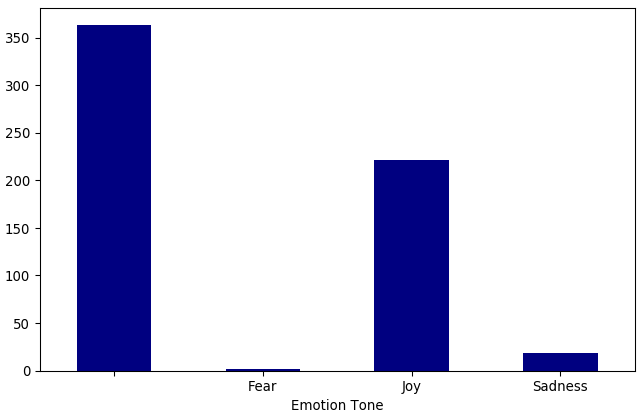

In [ ]:
display(tones)

#### Now let's look at the same statistics as a bar chart.

It is the same line of code. Use the `Edit Metadata` button to see how PixieDust knows to show us a bar chart. If you don't have a button use the menu and select `View > Cell Toolbar > Edit Metadata`.

A bar chart is better at showing more information. We added `Cluster By: Type` so we already see numbers for posts and articles. Notice what the chart tells you. *Joy* seems to be the dominant emotion. Click on `Options` and try this:

* Change the aggregation to `AVG`.

What emotion leads to higher average consumption?



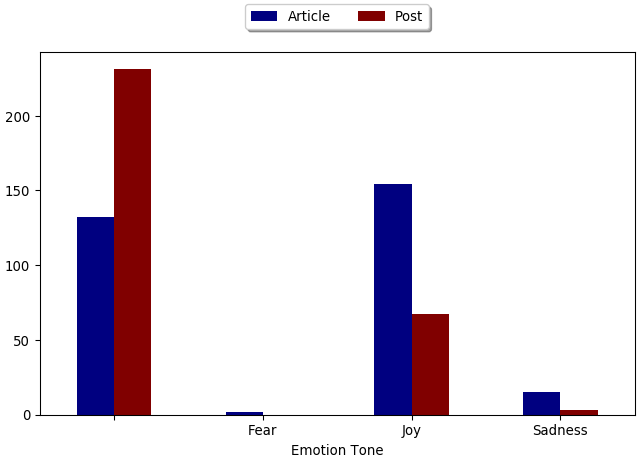

In [ ]:
display(tones)

#### Now let's look at the entities that were detected by Natural Language Understanding.

The following bar chart shows the entities that were detected. This time we are stacking negative feedback and "likes" to get a picture of the kind of feedback the entities were getting. We chose a horizontal, stacked bar chart with descending values for a little variety.

* Try a different renderer and see what you get.


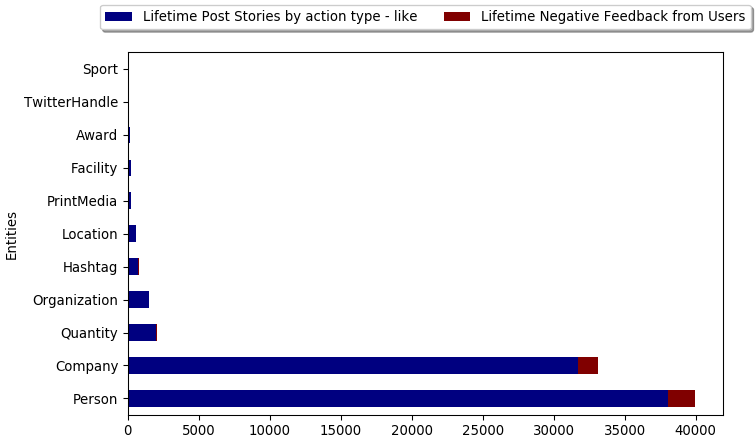

In [ ]:
display(entities)

#### Next we look at the keywords detected by Natural Language Understanding



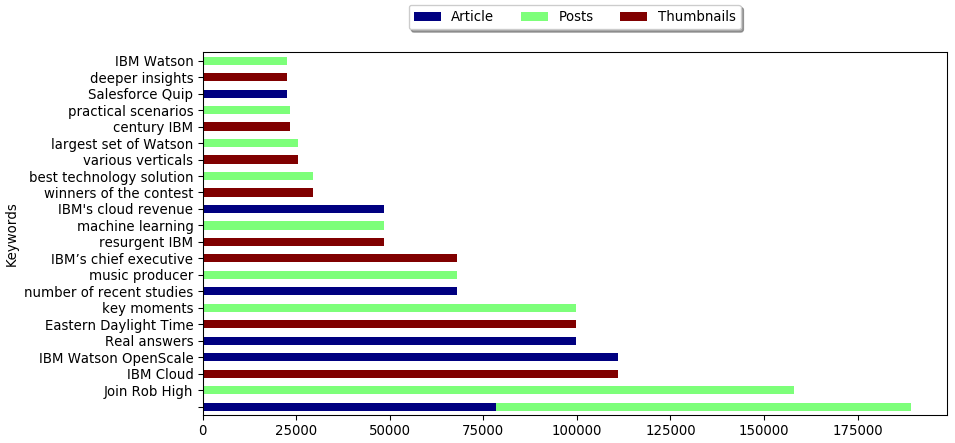

In [46]:
display(keywords)

#### Now let's take a look at what Visual Recognition can show us.

See how the images influenced the metrics. We've used visual recognition to identify a class and a type hierarchy for each image. We've also captured the top recognized color for each image. Our sample data doesn't have a significant number of data points, but these three charts demonstrate how you could:

1. Recognize image classes that correlate to higher total reach.
1. Add a type hierarchy for a higher level abstraction or to add grouping/stacking to the class data.
1. Determine if image color correlates to total reach.

Visual recognition makes it surprisingly easy to do all of the above. Of course, you can easily try different metrics as you experiment. If you are not convinced that you should add ultramarine laser pictures to all of your articles, then you might want to do some research with a better data sample.

In [47]:
display(df_pic_keywords)


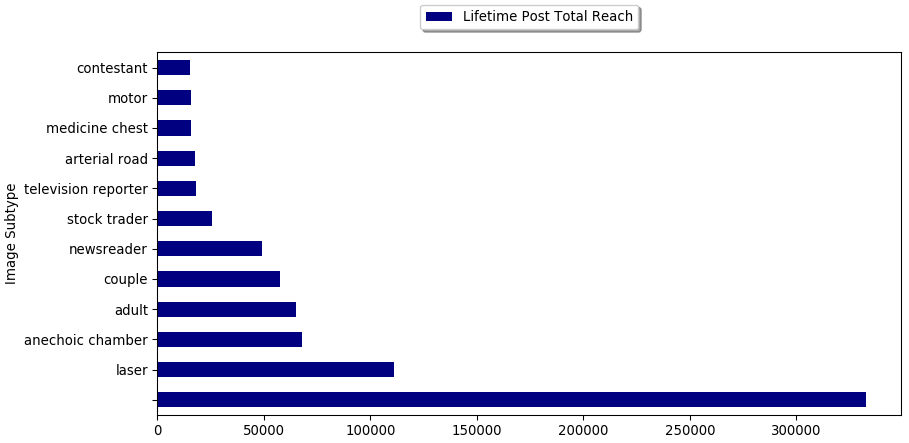

In [48]:
display(df_pic_keywords)


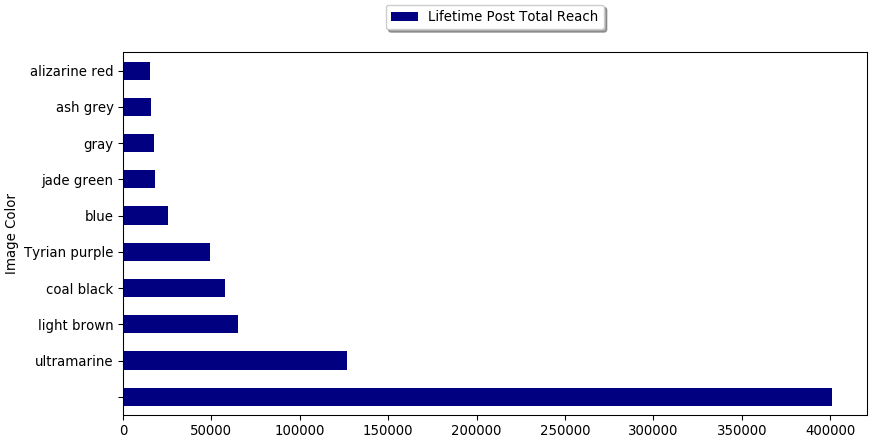

In [49]:
display(df_pic_keywords)

# More Info.
For more information about PixieDust, check out the following:
* PixieDust Documentation: https://pixiedust.github.io/pixiedust/
* PixieDust GitHub Repo: https://github.com/pixiedust/pixiedust

Visit the With Watson page to learn more about the work we are doing with our partners to make Watson and Watson Studio come to life for our clients
* With Watson Page: https://www.ibm.com/watson/with-watson/


### About the Authors:
#### Tyler Andersen and Anna Quincy
Tyler and Anna are part of the With Watson team focused on pairing Cognitive Services with Data Science Patterns and Techniques for clients around the world. They work directly with clients to determine how they can use Watson and IBM's Watson Studio with their own data to solve a wide range of business issues.
 
#### Mark Sturdevant
Mark is a Developer Advocate at IBM where he implements open source code patterns to guide developers as they innovate using IBM's AI and data analytics solutions with Watson and Watson Studio.

<hr>
Copyright © IBM Corp. 2017, 2018. This notebook and its source code are released under the terms of the Apache 2.0.

Licensed under the Apache License, Version 2.0 (the "License"); you may
not use this file except in compliance with the License. You may obtain
a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License.